In [1]:
!date

Fri Jul  9 17:14:41 PDT 2021


# TSS DE

In [2]:
!mkdir plots tables

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘tables’: File exists


In [3]:
import sys

colab = "google.colab" in sys.modules

if colab:
    # download files
    !git clone https://github.com/pachterlab/BYVSTZP_2020.git
    !wget -q --show-progress --progress=bar:force -O gene.h5ad.gz https://caltech.box.com/shared/static/2qut50hmb5r2zynd0dkihlj0qpwi6576.gz 2>&1
    !wget -q --show-progress --progress=bar:force -O isoform.h5ad.gz https://caltech.box.com/shared/static/7n6n9fvs2737shskqaiamw0dob9rbwva.gz 2>&1
    !gunzip *.gz

    !pip install --quiet anndata

In [4]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [6]:
gene = anndata.read_h5ad("gene.h5ad")
isoform = anndata.read_h5ad("isoform.h5ad")

In [7]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [8]:
isoform.var

,transcript_id,gene_id,gene_name,transcript_name,length,gene_counts,highly_variable,means,dispersions,dispersions_norm
Gnai3-201_ENSMUST00000000001,ENSMUST00000000001,ENSMUSG00000000001,Gnai3_ENSMUSG00000000001,Gnai3-201_ENSMUST00000000001,3262,79127.781250,False,2.612575,3.501746,0.137878
Cdc45-201_ENSMUST00000000028,ENSMUST00000000028,ENSMUSG00000000028,Cdc45_ENSMUSG00000000028,Cdc45-201_ENSMUST00000000028,2143,4536.083008,False,0.552307,3.328596,0.459652
Cdc45-204_ENSMUST00000231819,ENSMUST00000231819,ENSMUSG00000000028,Cdc45_ENSMUSG00000000028,Cdc45-204_ENSMUST00000231819,1484,1161.080811,False,0.165365,0.465818,-2.672809
Cdc45-203_ENSMUST00000115585,ENSMUST00000115585,ENSMUSG00000000028,Cdc45_ENSMUSG00000000028,Cdc45-203_ENSMUST00000115585,832,864.703430,False,0.126926,2.782908,0.021513
Cdc45-202_ENSMUST00000096990,ENSMUST00000096990,ENSMUSG00000000028,Cdc45_ENSMUSG00000000028,Cdc45-202_ENSMUST00000096990,1747,2633.873779,False,0.356364,3.155828,0.455146
...,...,...,...,...,...,...,...,...,...,...
CT030713.2-201_ENSMUST00000231951,ENSMUST00000231951,ENSMUSG00000116984,CT030713.2_ENSMUSG00000116984,CT030713.2-201_ENSMUST00000231951,2172,3135.330566,False,0.398416,0.675728,-2.428726
AC150035.3-201_ENSMUST00000232135,ENSMUST00000232135,ENSMUSG00000116987,AC150035.3_ENSMUSG00000116987,AC150035.3-201_ENSMUST00000232135,1004,1177.366943,False,0.175106,3.359726,0.692240
AC164314.2-201_ENSMUST00000232307,ENSMUST00000232307,ENSMUSG00000116988,AC164314.2_ENSMUSG00000116988,AC164314.2-201_ENSMUST00000232307,2610,5286.683594,False,0.597659,2.866518,-0.153608
AC131339.4-201_ENSMUST00000231361,ENSMUST00000231361,ENSMUSG00000116989,AC131339.4_ENSMUSG00000116989,AC131339.4-201_ENSMUST00000231361,498,5846.850098,True,0.651191,3.958315,1.295401


In [9]:
isoform.var["idx"] = np.arange(isoform.var.shape[0])

Trying to set attribute `.var` of view, copying.


# New t2g

In [10]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("BYVSTZP_2020/reference/kb/t2g.txt", sep="\t", header=None, names=cols)

In [11]:
t2g["transcript_id"] = t2g["transcript_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_id"].str.slice(0,18)

In [12]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [13]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

In [14]:
t2g.index = t2g.transcript_id.values

# Group isoforms by (1) Gene and then (2) Transcripton start sites

In [15]:
gb = t2g.groupby(["chromosome", "gene_id", "new_start"])["transcript_id"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_id":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [16]:
gb["n_tss_same"]    = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene   = t2g.groupby("gene_id")["transcript_id"].count()
max_tss_set_size    = gb.groupby("gene_id")["tss_len"].apply(max)
num_tss_with_1_iso  = gb.groupby("gene_id")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"]         = gb["gene_id"].map(num_iso_per_gene)
gb["max_tss_size"]  = gb["gene_id"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_id"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [17]:
gb.head()

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
0,1,ENSMUSG00000000544,166130238,[ENSMUST00000060833],1,1,4,1,4,0
1,1,ENSMUSG00000000544,166130340,[ENSMUST00000166159],1,1,4,1,4,1
2,1,ENSMUSG00000000544,166130417,[ENSMUST00000027847],1,1,4,1,4,2
3,1,ENSMUSG00000000544,166130467,[ENSMUST00000166860],1,1,4,1,4,3
4,1,ENSMUSG00000000817,161788358,[ENSMUST00000193648],1,1,2,1,2,4


In [18]:
## Conditions
# 1. n_iso per gene > 2
# 2. 2< n_TSS_same < n_iso
mask = np.logical_and(gb["max_tss_size"]>1, np.logical_and(gb["n_iso"] > 2, gb["n_tss_same"] < gb["n_iso"]))

ft2g = gb[mask]

09-Jul-21 17:15:13 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
09-Jul-21 17:15:13 - NumExpr defaulting to 8 threads.


In [19]:
gid2gene = t2g[~t2g["gene_id"].duplicated()]
gid2gene.index = gid2gene.gene_id.values

In [20]:
gid2gene["gene_name"] = gid2gene["gene_name"] + "_" + gid2gene["gene_id"]

In [21]:
ft2g

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
6,1,ENSMUSG00000001138,36511867,"[ENSMUST00000001166, ENSMUST00000097776]",2,2,5,2,3,6
7,1,ENSMUSG00000001138,36513097,[ENSMUST00000154225],1,1,5,2,3,7
8,1,ENSMUSG00000001138,36518569,[ENSMUST00000195264],1,1,5,2,3,8
9,1,ENSMUSG00000001138,36520761,[ENSMUST00000135100],1,1,5,2,3,9
10,1,ENSMUSG00000001143,36428366,[ENSMUST00000152088],1,1,8,4,4,10
...,...,...,...,...,...,...,...,...,...,...
102876,Y,ENSMUSG00000104425,21575870,[ENSMUST00000192545],1,1,3,2,1,102876
102880,Y,ENSMUSG00000104500,24276290,"[ENSMUST00000194662, ENSMUST00000195661]",2,2,3,2,1,102880
102881,Y,ENSMUSG00000104500,24276742,[ENSMUST00000194949],1,1,3,2,1,102881
102882,Y,ENSMUSG00000104505,12516355,"[ENSMUST00000191901, ENSMUST00000193731]",2,2,3,2,1,102882


In [22]:
t2g.head()

,transcript_id,gene_id,gene_name,transcript_name,chromosome,start,stop,strand,new_start,new_stop
ENSMUST00000162897,ENSMUST00000162897,ENSMUSG00000051951,Xkr4,Xkr4-203,1,3205901,3216344,-,3216344,3205901
ENSMUST00000159265,ENSMUST00000159265,ENSMUSG00000051951,Xkr4,Xkr4-202,1,3206523,3215632,-,3215632,3206523
ENSMUST00000070533,ENSMUST00000070533,ENSMUSG00000051951,Xkr4,Xkr4-201,1,3214482,3671498,-,3671498,3214482
ENSMUST00000161581,ENSMUST00000161581,ENSMUSG00000089699,Gm1992,Gm1992-201,1,3466587,3513553,+,3466587,3513553
ENSMUST00000194643,ENSMUST00000194643,ENSMUSG00000102343,Gm37381,Gm37381-202,1,3905739,3986215,-,3986215,3905739


In [23]:
ft2g["gene_name"] = ft2g.gene_id.map(gid2gene["gene_name"])
ft2g["tss_same_name"] = ft2g.tss_same.apply(lambda x: [t2g.loc[i]["transcript_name"] + "_" + t2g.loc[i]["transcript_id"] for i in x])

In [24]:
ft2g.head()

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,gene_name,tss_same_name
6,1,ENSMUSG00000001138,36511867,"[ENSMUST00000001166, ENSMUST00000097776]",2,2,5,2,3,6,Cnnm3_ENSMUSG00000001138,"[Cnnm3-201_ENSMUST00000001166, Cnnm3-202_ENSMU..."
7,1,ENSMUSG00000001138,36513097,[ENSMUST00000154225],1,1,5,2,3,7,Cnnm3_ENSMUSG00000001138,[Cnnm3-204_ENSMUST00000154225]
8,1,ENSMUSG00000001138,36518569,[ENSMUST00000195264],1,1,5,2,3,8,Cnnm3_ENSMUSG00000001138,[Cnnm3-205_ENSMUST00000195264]
9,1,ENSMUSG00000001138,36520761,[ENSMUST00000135100],1,1,5,2,3,9,Cnnm3_ENSMUSG00000001138,[Cnnm3-203_ENSMUST00000135100]
10,1,ENSMUSG00000001143,36428366,[ENSMUST00000152088],1,1,8,4,4,10,Lman2l_ENSMUSG00000001143,[Lman2l-206_ENSMUST00000152088]


In [25]:
# remove the tss classes where a single isoform has been discarded
ft2g["filter"] = ft2g.tss_same.apply(lambda x: np.array([i not in isoform.var.transcript_id.values for i in x]).sum())
ft2g = ft2g[ft2g["filter"]==0]

In [26]:
ft2g.head()

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,gene_name,tss_same_name,filter
6,1,ENSMUSG00000001138,36511867,"[ENSMUST00000001166, ENSMUST00000097776]",2,2,5,2,3,6,Cnnm3_ENSMUSG00000001138,"[Cnnm3-201_ENSMUST00000001166, Cnnm3-202_ENSMU...",0
9,1,ENSMUSG00000001138,36520761,[ENSMUST00000135100],1,1,5,2,3,9,Cnnm3_ENSMUSG00000001138,[Cnnm3-203_ENSMUST00000135100],0
11,1,ENSMUSG00000001143,36439668,[ENSMUST00000192969],1,1,8,4,4,11,Lman2l_ENSMUSG00000001143,[Lman2l-207_ENSMUST00000192969],0
12,1,ENSMUSG00000001143,36441872,[ENSMUST00000134594],1,1,8,4,4,12,Lman2l_ENSMUSG00000001143,[Lman2l-205_ENSMUST00000134594],0
13,1,ENSMUSG00000001143,36445257,[ENSMUST00000193502],1,1,8,4,4,13,Lman2l_ENSMUSG00000001143,[Lman2l-208_ENSMUST00000193502],0


In [27]:
et2g = ft2g.explode("tss_same_name")

In [28]:
dtss_tname = ft2g["tss_same_name"].to_dict()
l = list(dtss_tname.values())
flatten = lambda l: [item for sublist in l for item in sublist]
lf = flatten(l)

In [29]:
list(dtss_tname.values())[0:10]

[['Cnnm3-201_ENSMUST00000001166', 'Cnnm3-202_ENSMUST00000097776'],
 ['Cnnm3-203_ENSMUST00000135100'],
 ['Lman2l-207_ENSMUST00000192969'],
 ['Lman2l-205_ENSMUST00000134594'],
 ['Lman2l-208_ENSMUST00000193502'],
 ['Lman2l-204_ENSMUST00000125304',
  'Lman2l-202_ENSMUST00000115011',
  'Lman2l-201_ENSMUST00000001171',
  'Lman2l-203_ENSMUST00000123583'],
 ['Rgs20-203_ENSMUST00000119256'],
 ['Rgs20-207_ENSMUST00000170566', 'Rgs20-206_ENSMUST00000156289'],
 ['Rgs20-201_ENSMUST00000002533'],
 ['Ncstn-203_ENSMUST00000135928']]

In [30]:
lf[0:10]

['Cnnm3-201_ENSMUST00000001166',
 'Cnnm3-202_ENSMUST00000097776',
 'Cnnm3-203_ENSMUST00000135100',
 'Lman2l-207_ENSMUST00000192969',
 'Lman2l-205_ENSMUST00000134594',
 'Lman2l-208_ENSMUST00000193502',
 'Lman2l-204_ENSMUST00000125304',
 'Lman2l-202_ENSMUST00000115011',
 'Lman2l-201_ENSMUST00000001171',
 'Lman2l-203_ENSMUST00000123583']

In [31]:
tmp_iso = isoform[:, isoform.var.transcript_name.isin(lf)]
tmp_iso

View of AnnData object with n_obs × n_vars = 6160 × 22905
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'idx'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'

In [32]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new entry
                inverse[item] = key
    return inverse

In [33]:
tmp_iso.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length,gene_counts,highly_variable,means,dispersions,dispersions_norm,idx
Brat1-201_ENSMUST00000041588,ENSMUST00000041588,ENSMUSG00000000148,Brat1_ENSMUSG00000000148,Brat1-201_ENSMUST00000041588,3333,15101.863281,False,1.216869,2.979520,-0.177377,70
Brat1-205_ENSMUST00000131905,ENSMUST00000131905,ENSMUSG00000000148,Brat1_ENSMUSG00000000148,Brat1-205_ENSMUST00000131905,2185,2064.809814,False,0.281965,2.983169,0.254377,72
Brat1-204_ENSMUST00000124892,ENSMUST00000124892,ENSMUSG00000000148,Brat1_ENSMUSG00000000148,Brat1-204_ENSMUST00000124892,3179,2744.497314,False,0.365425,3.020729,0.298052,73
Brat1-202_ENSMUST00000100505,ENSMUST00000100505,ENSMUSG00000000148,Brat1_ENSMUSG00000000148,Brat1-202_ENSMUST00000100505,3431,2670.760254,False,0.355323,2.785280,0.024271,74
Ccnd2-201_ENSMUST00000000188,ENSMUST00000000188,ENSMUSG00000000184,Ccnd2_ENSMUSG00000000184,Ccnd2-201_ENSMUST00000000188,6330,72230.492188,False,2.511866,2.871280,-0.854097,90


In [34]:
dtname_tss = invert_dict(dtss_tname)
tmp_iso.var["tss_class"] = tmp_iso.var.transcript_name.map(dtname_tss)

Trying to set attribute `.var` of view, copying.


In [35]:
(~ft2g[ft2g["tss_class"].isin(tmp_iso.var["tss_class"])]["tss_same_name"].explode().isin(isoform.var.transcript_name)).sum()

0

In [36]:
def sum_tss_same(mtx, components, features):
    
    unique = np.unique(features)
    nuniq = unique.shape[0]
    ncomp = components.shape[0]
    
    s_mtx = np.zeros((ncomp, nuniq))
    
    for uidx, u in enumerate(unique):
        mask = features == u
        s_mtx[:,uidx] = np.asarray(mtx[:,mask].sum(axis=1)).reshape(-1)
    
    return s_mtx, unique

In [37]:
# sum the isoforms with the same start site
features = tmp_iso.var.tss_class.values
components = tmp_iso.obs.cell_id.values
mtx = tmp_iso.layers["X"].todense()
# sum the raw counts then normalize and log?

mtx, unique = sum_tss_same(mtx, components, features)

In [38]:
X = mtx
obs = isoform.obs
var = ft2g.loc[unique]
var["idx"] = np.arange(var.shape[0])

stss = anndata.AnnData(X=X, obs=obs, var=var)
stss.var.index = stss.var.index.astype(int)

In [39]:
stss.layers["X"] = X

In [40]:
from sklearn.preprocessing import normalize

In [41]:
stss.layers["norm"] = normalize(stss.layers["X"], norm='l1', axis=1)*1000000

In [42]:
stss.layers["norm"][0].sum()

1000000.0

In [43]:
stss.layers["log1p"] = np.log1p(stss.layers["norm"])

In [44]:
stss.X = csr_matrix(stss.X)

In [45]:
stss.layers["log1p"] = csr_matrix(stss.layers["log1p"])

In [46]:
stss.layers["X"] = csr_matrix(stss.layers["X"])

# DE

In [47]:
stss.var.index = stss.var.index.astype(str)

In [48]:
stss = stss[:,stss.var.sort_values("tss_class").index]
tmp_iso = tmp_iso[:,tmp_iso.var.sort_values("tss_class").index]

In [49]:
%%time
mat           = stss.layers["log1p"].todense()
components    = stss.obs.cell_id.values
features      = stss.var.tss_class.values
assignments   = stss.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"

p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_stss = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_stss["p_corr"][markers_stss.eval("p_corr == 0").values] = sys.float_info.min
markers_stss = markers_stss.query("es > 0")

09-Jul-21 17:16:59 - 1 of 4 assignments: GABAergic
09-Jul-21 17:16:59 - 2 of 4 assignments: Glutamatergic
09-Jul-21 17:17:00 - 3 of 4 assignments: Low Quality
09-Jul-21 17:17:00 - 4 of 4 assignments: Non-Neuronal


CPU times: user 1.28 s, sys: 1.4 s, total: 2.68 s
Wall time: 2.67 s


In [50]:
%%time
mat         = tmp_iso.layers["log1p"].todense() # expects dense matrix
components  = tmp_iso.obs.cell_id.values
features    = tmp_iso.var.transcript_name.values
assignments = tmp_iso.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

09-Jul-21 17:17:02 - 1 of 4 assignments: GABAergic
09-Jul-21 17:17:02 - 2 of 4 assignments: Glutamatergic
09-Jul-21 17:17:03 - 3 of 4 assignments: Low Quality
09-Jul-21 17:17:03 - 4 of 4 assignments: Non-Neuronal


CPU times: user 1.5 s, sys: 1.75 s, total: 3.25 s
Wall time: 3.24 s


In [51]:
markers_isoform.shape

(1971, 5)

In [52]:
markers_stss.shape

(2047, 5)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [53]:
markers_stss["name"] = markers_stss["name"].astype(int)

tmp = pd.Series(et2g["tss_same_name"].index.values, index=et2g["tss_same_name"].values )

markers_isoform["tss_class"] = markers_isoform.name.map(tmp).values

In [54]:
stss.var.index = stss.var.index.astype(int).values

In [55]:
alpha =0.01
fc = 2

markers_stss["index_name"] = markers_stss["index"] + "_" + markers_stss.name.astype(str)
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.tss_class.astype(str)

relevant_stss = (markers_stss.p_corr < alpha).values

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_stss[relevant_stss]["index_name"].values)

In [56]:
setdiff.shape

(873,)

In [57]:
markers_isoform.eval(f"p_corr<{alpha}").sum()

1048

In [58]:
markers_isoform[markers_isoform["index_name"].isin(setdiff).values].eval(f"p_corr<{alpha}").sum()

31

In [59]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff).values].query(f"p_corr < {alpha}")

In [60]:
markers_isoform.query("index != 'Low Quality'").sort_values("es")

,index,name,p_raw,p_corr,es,tss_class,index_name
44989,Glutamatergic,Ubl5-204_ENSMUST00000160682,0.000000,0.000277,0.068685,97677,Glutamatergic_97677
39646,Glutamatergic,Atp6v1f-201_ENSMUST00000004396,0.000000,0.000003,0.079910,72661,Glutamatergic_72661
41867,Glutamatergic,Ypel3-211_ENSMUST00000206143,0.000001,0.001395,0.083819,83130,Glutamatergic_83130
20780,GABAergic,Kmt2a-201_ENSMUST00000002095,0.000000,0.000133,0.097342,92332,GABAergic_92332
20781,GABAergic,Kmt2a-202_ENSMUST00000114689,0.000000,0.000000,0.103047,92332,GABAergic_92332
32830,Glutamatergic,Rtn3-201_ENSMUST00000025667,0.000000,0.000186,0.103122,43737,Glutamatergic_43737
43086,Glutamatergic,Ciapin1-210_ENSMUST00000162589,0.000000,0.000000,0.110808,89213,Glutamatergic_89213
29618,Glutamatergic,Pfdn5-201_ENSMUST00000001335,0.000000,0.000002,0.115533,30443,Glutamatergic_30443
43012,Glutamatergic,Tecr-201_ENSMUST00000019382,0.000001,0.000590,0.121117,89015,Glutamatergic_89015
27370,Glutamatergic,Srsf5-212_ENSMUST00000153056,0.000000,0.000000,0.169609,19304,Glutamatergic_19304


In [61]:
#tss_0 = 28892
specific_gene = "Rtn1"
specific_cluster = "GABAergic"

In [62]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Rtn1_ENSMUSG00000021087'], dtype=object)

In [63]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [64]:
specific_gene

'Rtn1_ENSMUSG00000021087'

In [65]:
et2g.query(f"gene_name =='{specific_gene}'")

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,gene_name,tss_same_name,filter
19173,12,ENSMUSG00000021087,72235739,[ENSMUST00000150156],1,1,6,2,4,19173,Rtn1_ENSMUSG00000021087,Rtn1-205_ENSMUST00000150156,0
19174,12,ENSMUSG00000021087,72236548,[ENSMUST00000221756],1,1,6,2,4,19174,Rtn1_ENSMUSG00000021087,Rtn1-206_ENSMUST00000221756,0
19175,12,ENSMUSG00000021087,72236686,[ENSMUST00000144181],1,1,6,2,4,19175,Rtn1_ENSMUSG00000021087,Rtn1-204_ENSMUST00000144181,0
19176,12,ENSMUSG00000021087,72236724,"[ENSMUST00000021497, ENSMUST00000137990]",2,2,6,2,4,19176,Rtn1_ENSMUSG00000021087,Rtn1-201_ENSMUST00000021497,0
19176,12,ENSMUSG00000021087,72236724,"[ENSMUST00000021497, ENSMUST00000137990]",2,2,6,2,4,19176,Rtn1_ENSMUSG00000021087,Rtn1-203_ENSMUST00000137990,0
19177,12,ENSMUSG00000021087,72409054,[ENSMUST00000078505],1,1,6,2,4,19177,Rtn1_ENSMUSG00000021087,Rtn1-202_ENSMUST00000078505,0


In [66]:
et2g.query(f"gene_name =='{specific_gene}'").tss_class.unique()

array([19173, 19174, 19175, 19176, 19177])

In [67]:
tss_0 = 19176
tss_1 = 19173, 19174, 19175, 19177,

In [68]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})

    
    return ax


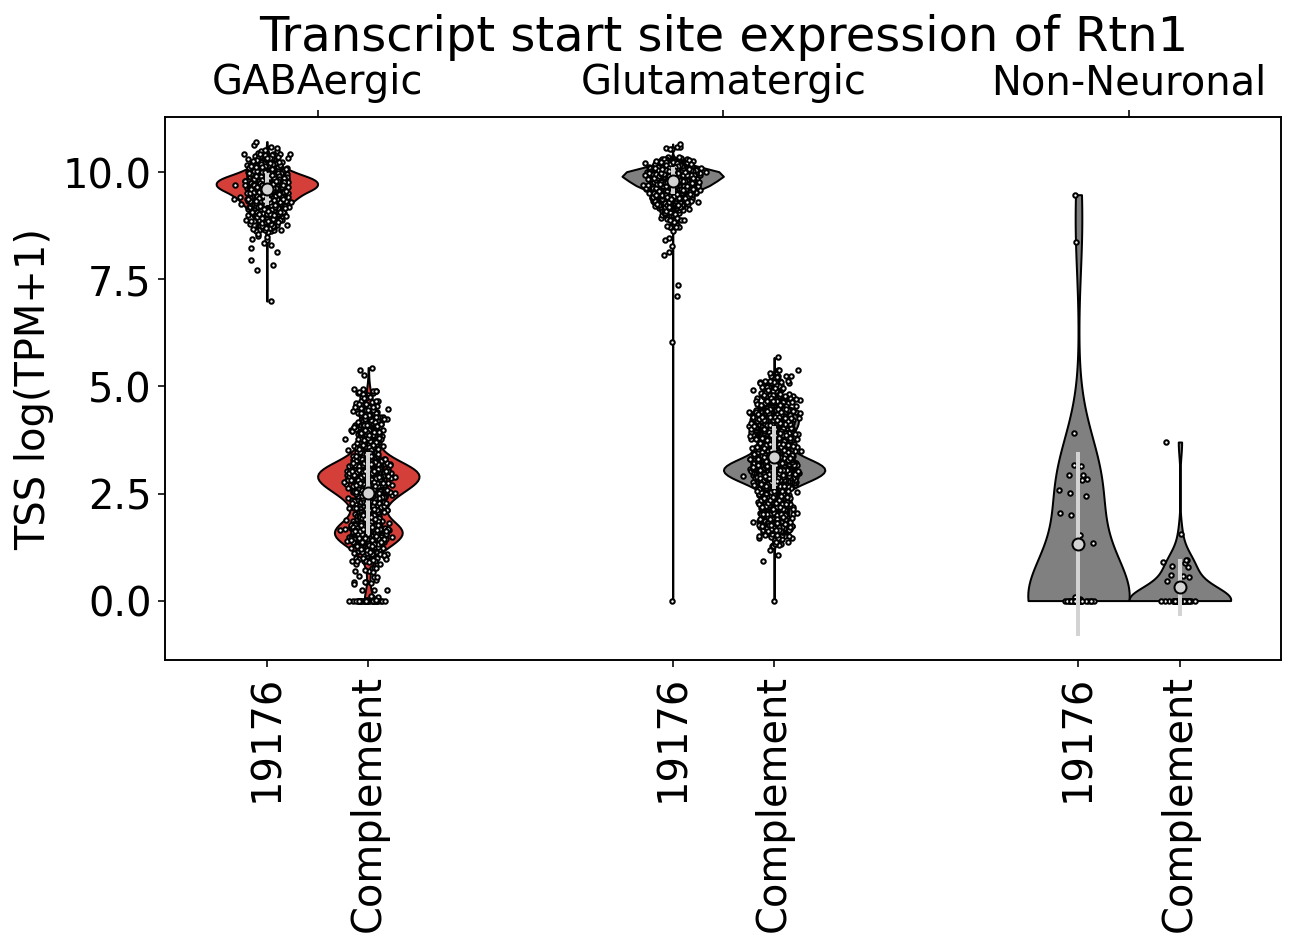

In [69]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)


lridx = np.union1d(lidx, ridx)
sub_labels = [tss_0, "Complement"]*len(lidx)

mat = stss.layers["log1p"].todense()
obs = stss.obs
var = stss.var


x = []
y = []
for c in unique:
    tmp_mat = mat[obs.class_label==c,:]
    
    x.append(np.asarray(tmp_mat[:,var.tss_class==tss_0]).reshape(-1).tolist())
    tmp = []
    for t in tss_1:
        tmp.append(np.asarray(tmp_mat[:,var.tss_class==t]).reshape(-1).tolist())
    y.append(np.array(tmp).mean(axis=0))
    #y.append(np.asarray(tmp_mat[:,var.tss_class==tss_1]).reshape(-1).tolist())

violinplot(x, ax, selected = midx,xticks = lidx)
violinplot(y, ax, selected = midx,xticks = ridx)

ax2 = ax.twiny()

ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax.set(**{
    "xticks": lridx,
    "ylabel": "TSS log(TPM+1)",
    "title": "Transcript start site expression of {}".format(specific_gene.split("_")[0])
})

ax2.set(**{
    "xlim": ax.get_xlim(),
    "xticks": cidx,
    "xticklabels": labels
})


plt.savefig("plots/tss_DE_tss_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight', dpi=300)

plt.show()

In [70]:
et2g[et2g.tss_class==tss_0]

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,gene_name,tss_same_name,filter
19176,12,ENSMUSG00000021087,72236724,"[ENSMUST00000021497, ENSMUST00000137990]",2,2,6,2,4,19176,Rtn1_ENSMUSG00000021087,Rtn1-201_ENSMUST00000021497,0
19176,12,ENSMUSG00000021087,72236724,"[ENSMUST00000021497, ENSMUST00000137990]",2,2,6,2,4,19176,Rtn1_ENSMUSG00000021087,Rtn1-203_ENSMUST00000137990,0


In [71]:
markers_isoform.query("name == 'Rtn1-203_ENSMUST00000137990'")

,index,name,p_raw,p_corr,es,tss_class,index_name
4432,GABAergic,Rtn1-203_ENSMUST00000137990,0.0,0.0,0.368989,19176,GABAergic_19176


In [72]:
iso0 = "Rtn1-201_ENSMUST00000021497"
iso1 = "Rtn1-203_ENSMUST00000137990"

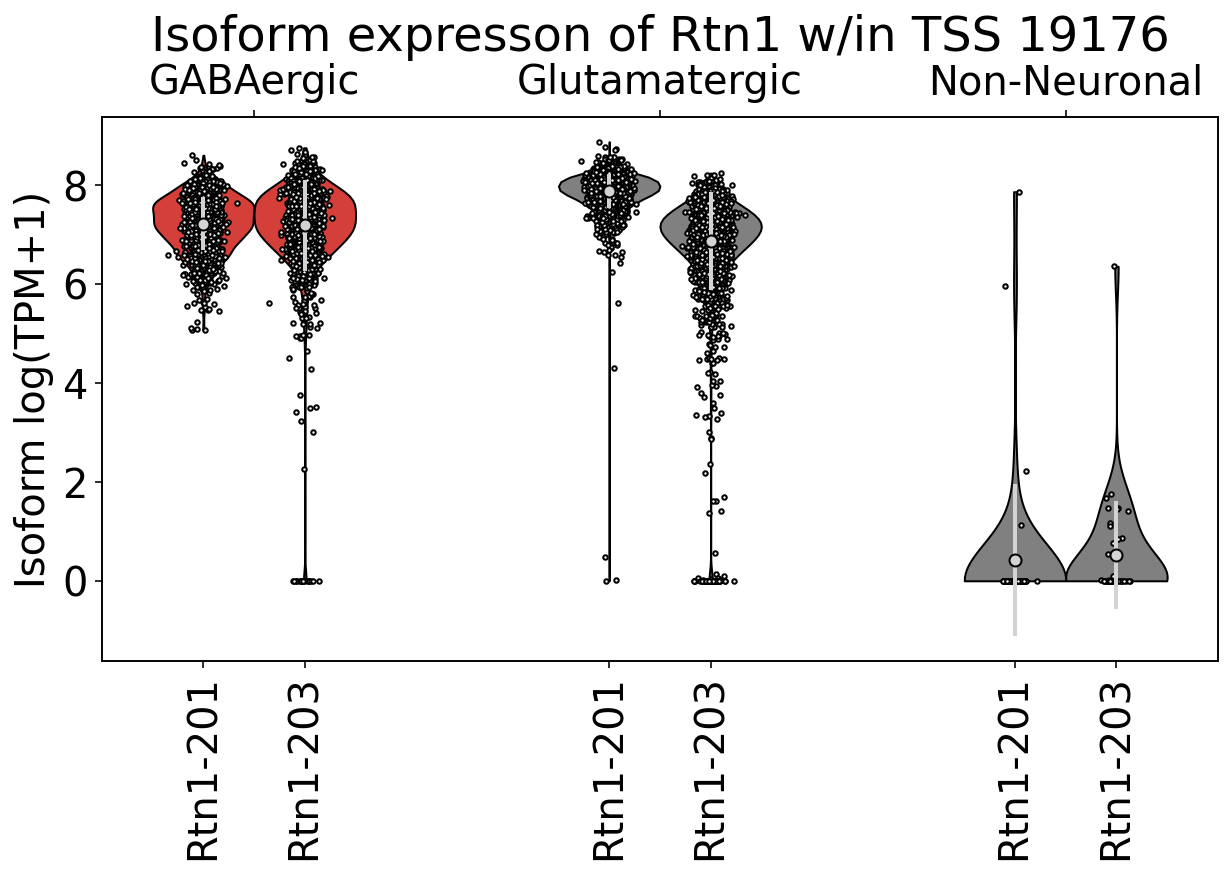

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(stss.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique


lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)

lridx = np.union1d(lidx, ridx)
sub_labels = [iso0.split("_")[0], iso1.split("_")[0]]*len(lidx)

mat = tmp_iso.layers["log1p"].todense()
obs = tmp_iso.obs
var = tmp_iso.var



x = []
y = []
for c in unique:
    tmp_mat = mat[obs.class_label==c,:]
    
    x.append(np.asarray(tmp_mat[:,var.transcript_name==iso0]).reshape(-1).tolist())
    y.append(np.asarray(tmp_mat[:,var.transcript_name==iso1]).reshape(-1).tolist())
    
violinplot(x, ax, selected = midx,xticks = lidx)
violinplot(y, ax, selected = midx,xticks = ridx)

ax2 = ax.twiny()

ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax.set(**{
    "xticks": lridx,
    "ylabel": "Isoform log(TPM+1)",
    "title": "Isoform expresson of {} w/in TSS {}".format(specific_gene.split("_")[0], tss_0)
})

ax2.set(**{
    "xlim": ax.get_xlim(),
    "xticks": cidx,
    "xticklabels": labels
})

plt.savefig("plots/ss_DE_isoform_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight', dpi=300)

plt.show()

In [74]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [75]:
identified_tss = markers_isoform["tss_class"].explode()

In [76]:
print("{} isoforms from {} tss classes identified.".format(identified_isoforms.shape[0], identified_tss.nunique()))

31 isoforms from 28 tss classes identified.


In [77]:
stss.var.explode("tss_same_name").to_csv("tables/tss2txn.csv")

In [78]:
markers_isoform.to_csv("tables/tss_isoform_DE.csv")